# How have the types of games or machines installed at bases changed over time?

This notebook explores how the mix and volume of gaming machines installed at bases changes from fiscal year 2021 through 2024, using the **Asset Report Final** tables.

If your folder or file names differ, edit the `base_dir` or filename patterns in the next cell.

by Quoc Dat Nguyen

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (10, 6)

print('Pandas version:', pd.__version__)

Pandas version: 2.3.3


## Load asset details for FY2020–FY2024

We loop over years, look for an `asset_details_YYYY.csv` in each year's `FYYYYY Asset Report Final` folder, and concatenate whatever we find into a single `assets` DataFrame.

In [16]:
import os
import pandas as pd

base_dir = r"C:\Users\dawid\Desktop\MUCKROCK\data\Asset Reports"
years = [2020, 2021, 2022, 2023, 2024]

assets_list = []

for year in years:
    year_folder = f"FY{year} Asset Report Final"
    csv_name = f"asset_details_FY{year}.csv"  # <-- your requested format
    csv_path = os.path.join(base_dir, year_folder, csv_name)

    if os.path.exists(csv_path):
        print(f"Loading {csv_path}")
        df = pd.read_csv(csv_path)
        df["Year"] = year
        assets_list.append(df)
    else:
        print(f"WARNING: Missing file: {csv_path}")

assets = pd.concat(assets_list, ignore_index=True)
assets.head()


Loading C:\Users\dawid\Desktop\MUCKROCK\data\Asset Reports\FY2020 Asset Report Final\asset_details_FY2020.csv
Loading C:\Users\dawid\Desktop\MUCKROCK\data\Asset Reports\FY2021 Asset Report Final\asset_details_FY2021.csv
Loading C:\Users\dawid\Desktop\MUCKROCK\data\Asset Reports\FY2022 Asset Report Final\asset_details_FY2022.csv
Loading C:\Users\dawid\Desktop\MUCKROCK\data\Asset Reports\FY2023 Asset Report Final\asset_details_FY2023.csv
Loading C:\Users\dawid\Desktop\MUCKROCK\data\Asset Reports\FY2024 Asset Report Final\asset_details_FY2024.csv


,Region,FONUM,FOSHORT,Loc,LNAME,Asset,Class,Desc,Type,Acquire,Effective,SerialNum,Month,Years_in_Storage,Age_int,Years_in_Storage_int,Year,Age,Years_in_Storage_float,BaseName_match,match_score,match_country,Latitude,Longitude,REGION,Aquire,PLACE,Years in Storage,Months
0,Europe,2,KAISERSLAUTERN,232,KAISERSLAUTERN F. O.,130582,740,IBM SUREPOS 4852,2038,10/15/2010,6/14/2013,130582-41C8993,NaN,0,NaN,0.0,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Europe,2,KAISERSLAUTERN,232,KAISERSLAUTERN F. O.,130620,740,IBM SUREPOS 4852,2038,10/15/2010,9/19/2014,130620-41D3295,NaN,0,NaN,0.0,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Europe,2,KAISERSLAUTERN,232,KAISERSLAUTERN F. O.,131727,740,IBM SUREPOS 4852,2038,10/15/2010,9/6/2013,131727-41D3169,NaN,0,NaN,0.0,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Europe,2,KAISERSLAUTERN,232,KAISERSLAUTERN F. O.,332966,70,DIEBOLD ACM,9001,2/14/2003,4/22/2016,332966-R10620538267,NaN,0,NaN,0.0,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Europe,2,KAISERSLAUTERN,232,KAISERSLAUTERN F. O.,333096,60,IGT GAME KING CL IFACE 210,228,12/10/2004,1/4/2020,333096-1407533,NaN,0,NaN,0.0,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Derive machine vendor / type and base name

The `Desc` field usually starts with a manufacturer or platform code (e.g., `IGT`, `NOV`, `WMS`).
We extract the first word of the description as a rough **machine vendor / type** label.

For base name, we try `BaseName_match` if present (a cleaned base name), and fall back to `LNAME`.

In [17]:
def infer_vendor(desc: str):
    if isinstance(desc, str) and desc.strip():
        return desc.split()[0]
    return 'Unknown'

assets['Vendor'] = assets['Desc'].apply(infer_vendor)

# Pick a base name column
if 'BaseName_match' in assets.columns:
    base_col = 'BaseName_match'
elif 'LNAME' in assets.columns:
    base_col = 'LNAME'
else:
    base_col = None

print('Using base column:', base_col)
assets[['Year', 'Vendor'] + ([base_col] if base_col else [])].head()

Using base column: BaseName_match


,Year,Vendor,BaseName_match
0,2020,IBM,NaN
1,2020,IBM,NaN
2,2020,IBM,NaN
3,2020,DIEBOLD,NaN
4,2020,IGT,NaN


## 1. Total number of machines per year

First, we simply count how many asset records we have for each year to see the overall size of the EGM fleet.

,Year,num_machines
0,2020,796
1,2021,621
2,2022,426
3,2023,1606
4,2024,1071


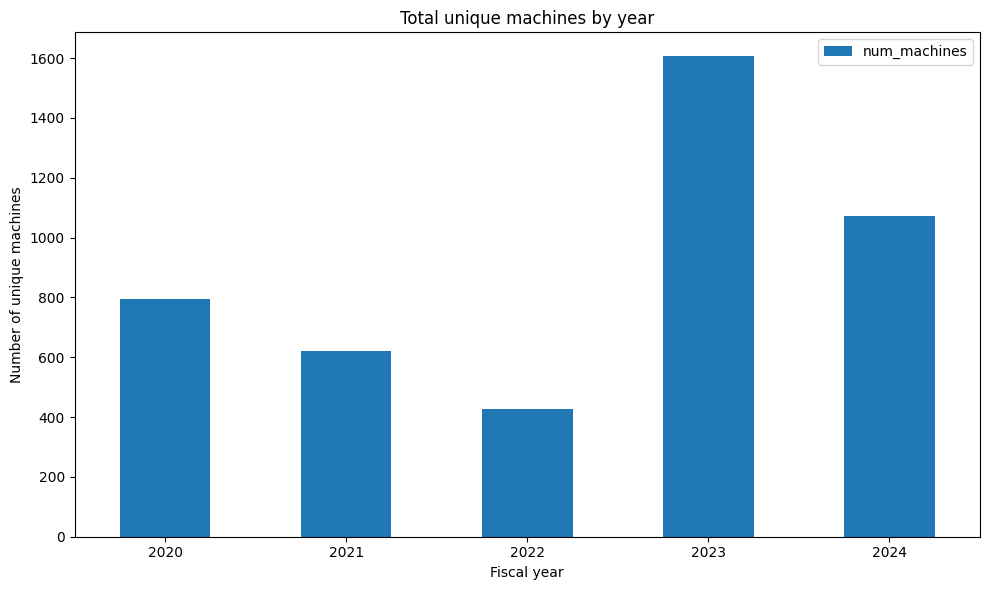

In [18]:
machines_per_year = assets.groupby('Year')['Asset'].nunique().reset_index(name='num_machines')
display(machines_per_year)

ax = machines_per_year.plot(x='Year', y='num_machines', kind='bar')
ax.set_title('Total unique machines by year')
ax.set_xlabel('Fiscal year')
ax.set_ylabel('Number of unique machines')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 2. Vendor / machine-type mix over time

Here we look at how the mix of machine **vendors/types** changes between years.
We:

1. Count machines by `Year` and `Vendor`.
2. Keep only the top vendors overall (to keep the chart legible).
3. Plot a stacked bar chart showing the distribution by year.

Vendor,AIN,ARI,BAL,IBM,IGT,ITC,KON,LNW,NOV,WMS
Year,,,,,,,,,,
2020,46.0,0.0,126.0,41.0,162.0,42.0,10.0,0.0,197.0,78.0
2021,7.0,0.0,88.0,45.0,94.0,43.0,17.0,0.0,182.0,74.0
2022,6.0,0.0,33.0,41.0,39.0,40.0,5.0,0.0,139.0,51.0
2023,60.0,197.0,155.0,55.0,232.0,58.0,84.0,150.0,334.0,110.0
2024,74.0,34.0,130.0,42.0,189.0,16.0,40.0,57.0,299.0,63.0


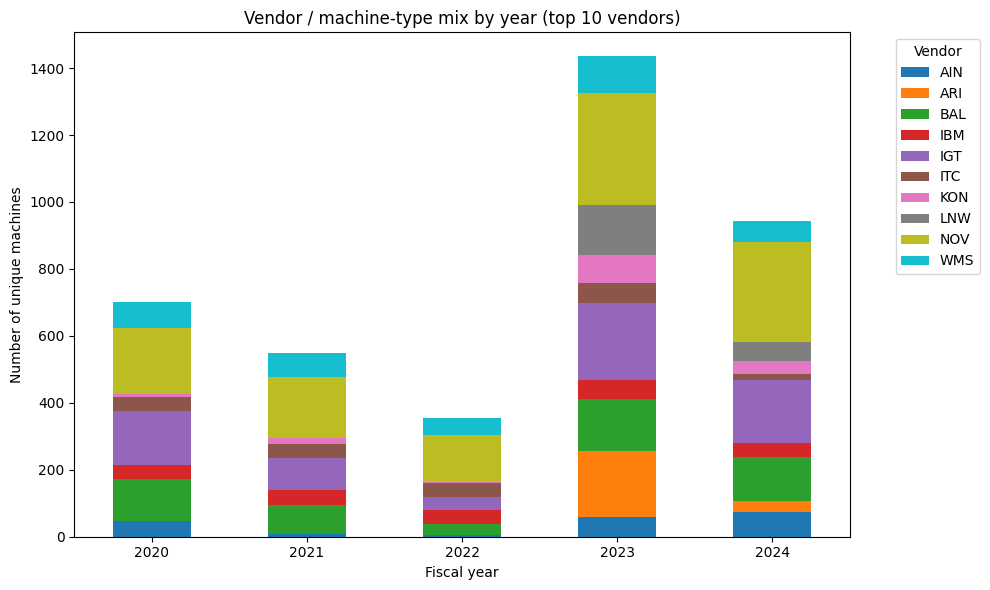

In [19]:
# Count machines per year and vendor
vendor_counts = (
    assets.groupby(['Year', 'Vendor'])['Asset']
    .nunique()
    .reset_index(name='num_machines')
)

# Focus on the top vendors across all years
top_vendors = (
    vendor_counts.groupby('Vendor')['num_machines']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

vendor_counts_top = vendor_counts[vendor_counts['Vendor'].isin(top_vendors)]

# Pivot to Year x Vendor table
vendor_pivot = vendor_counts_top.pivot(index='Year', columns='Vendor', values='num_machines').fillna(0)
display(vendor_pivot)

ax = vendor_pivot.plot(kind='bar', stacked=True)
ax.set_title('Vendor / machine-type mix by year (top 10 vendors)')
ax.set_xlabel('Fiscal year')
ax.set_ylabel('Number of unique machines')
plt.xticks(rotation=0)
plt.legend(title='Vendor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3. How machine counts at major bases change over time

If base information is available, we can look at how the number of installed machines changes at the busiest bases across years.

Using base column: Base


Base,DAEGU,KAISERSLAUTERN,OKINAWA,PYONGTAEK,SEOUL,VILSECK,YOKOSUKA,ZAMA
Year,,,,,,,,
2020,60,30,158,143,74,31,49,40
2021,49,46,118,128,6,35,32,45
2022,47,41,19,99,15,29,12,17
2023,129,196,275,155,55,92,87,144
2024,141,147,156,86,39,43,32,140


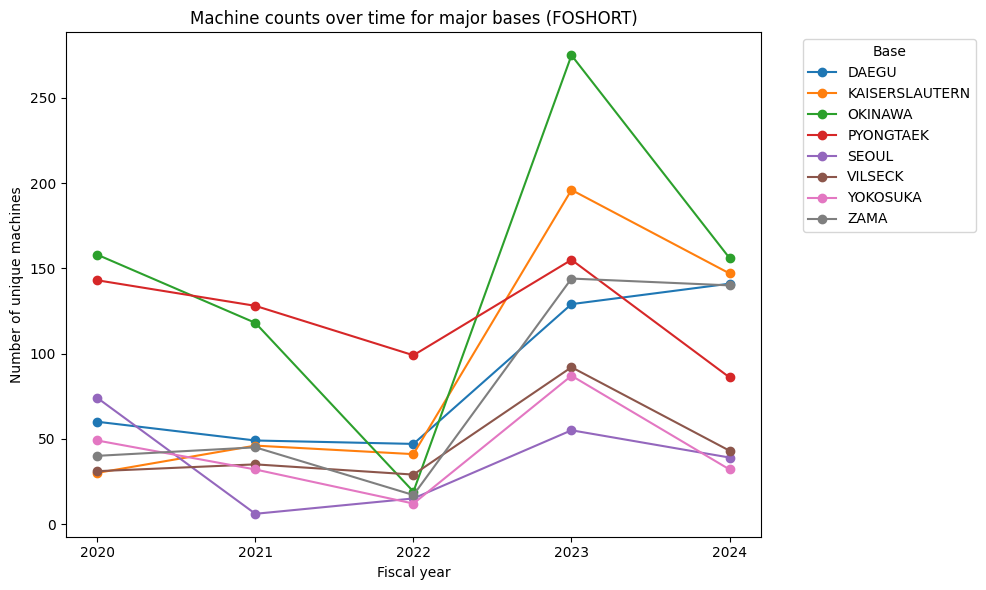

In [20]:
def infer_vendor(desc: str):
    if isinstance(desc, str) and desc.strip():
        return desc.split()[0]
    return "Unknown"

assets["Vendor"] = assets["Desc"].apply(infer_vendor)

# ---- NEW: use FOSHORT as the base name ----
if "FOSHORT" not in assets.columns:
    raise KeyError("FOSHORT column not found in asset_details data.")

assets["Base"] = assets["FOSHORT"]      # unified base name column
base_col = "Base"

print("Using base column:", base_col)
assets[["Year", "Vendor", base_col]].head()

# Machine counts over time for major bases, using FOSHORT
base_col = "Base"   # just to be explicit

# Find bases with the most machines overall
base_totals = (
    assets.groupby(base_col)["Asset"]
    .nunique()
    .sort_values(ascending=False)
)
top_bases = base_totals.head(8).index

base_year_counts = (
    assets[assets[base_col].isin(top_bases)]
    .groupby(["Year", base_col])["Asset"]
    .nunique()
    .reset_index(name="num_machines")
)

pivot_base = base_year_counts.pivot(
    index="Year", columns=base_col, values="num_machines"
).fillna(0)

display(pivot_base)

ax = pivot_base.plot(kind="line", marker="o")
ax.set_title("Machine counts over time for major bases (FOSHORT)")
ax.set_xlabel("Fiscal year")
ax.set_ylabel("Number of unique machines")
plt.xticks(pivot_base.index)
plt.legend(title="Base", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



## 4. Optional: Drill into a specific base or vendor

You can adapt the following template to focus on a particular base or vendor and see how its machines evolve over time.

In [21]:
# Example: filter to a single base or vendor and inspect details
# Edit these strings to match your data:
example_base = None  # e.g., 'Kaiserlautern'
example_vendor = None  # e.g., 'IGT'

query = assets.copy()
if base_col is not None and example_base:
    query = query[query[base_col] == example_base]
if example_vendor:
    query = query[query['Vendor'] == example_vendor]

print(f'Rows after filtering: {len(query)}')
query[['Year', 'Vendor'] + ([base_col] if base_col else []) + ['Desc', 'Asset']].head(20)

Rows after filtering: 19918


,Year,Vendor,Base,Desc,Asset
0,2020,IBM,KAISERSLAUTERN,IBM SUREPOS 4852,130582
1,2020,IBM,KAISERSLAUTERN,IBM SUREPOS 4852,130620
2,2020,IBM,KAISERSLAUTERN,IBM SUREPOS 4852,131727
3,2020,DIEBOLD,KAISERSLAUTERN,DIEBOLD ACM,332966
4,2020,IGT,KAISERSLAUTERN,IGT GAME KING CL IFACE 210,333096
5,2020,IGT,KAISERSLAUTERN,IGT FENG SHUI 10C 25L .01,333104
6,2020,IGT,KAISERSLAUTERN,IGT GAME KING CL IFACE 210,333115
7,2020,IGT,KAISERSLAUTERN,IGT GAME KING CL IFACE 210,333119
8,2020,DIEBOLD,KAISERSLAUTERN,DIEBOLD ACM,333218
9,2020,ITC,KAISERSLAUTERN,ITC Smart Card Dispenser,333419


## How have the types of games or machines installed at bases changed over time?

### Overview of machine-type changes (2020–2024)

From **2020 through 2022**, the system experienced a broad contraction across nearly all vendors. Each major manufacturer shows a noticeable decline in the number of unique machines installed, suggesting reduced operations or slowed procurement.

In **2023**, the system undergoes a dramatic expansion. The fleet nearly **triples in size**, indicating a coordinated, system-wide refresh cycle rather than isolated growth from individual vendors.

By **2024**, machine counts decrease from the 2023 peak, but remain **significantly higher than in 2021–2022**, suggesting stabilization rather than a full return to earlier contraction.

### Changes at individual bases (2020–2024)

The installation patterns at individual bases mirror the broader machine-type trends:

- **2020–2021:** Moderate declines at several bases, but not yet reaching the sharp lows seen later.
- **2021–2022:** Nearly every major base contracts. **Okinawa** experiences the steepest decline, possibly indicating temporary closure or large-scale deinstallation.
- **2023:** A system-wide surge, with significant machine deployments across nearly all bases. Many bases more than double their inventories.
- **2024:** A dip from 2023 levels, though still well above the suppressed counts of 2021–2022.

### Interpretation and context

The overall system appears to transition from a **modest fleet in 2020**, into a **contracting inventory in 2021–2022**, followed by a **major expansion and refresh in 2023**, and finally a **partial normalization in 2024**.

The unusually low machine counts in FY2021–FY2022 overlap with the operational impacts of the **COVID-19 pandemic**, which affected base facilities worldwide. While the dataset alone cannot establish causation, the timeline strongly aligns with pandemic-related restrictions and a subsequent **post-COVID recovery and modernization cycle**.

Overall, the period from 2020 to 2024 shows a shift from a smaller, contracting machine inventory to a much **larger and more diverse fleet**, with growth occurring across nearly all major bases and vendors.
